In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Dropout, Reshape, RepeatVector, TimeDistributed, Input, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load the dataset
df = pd.read_csv("dataset.csv")
df.index = pd.to_datetime(df["id"], errors="ignore")

# Columns for training
cols = ["humid", "ws40", "ws50", "ws60", "ws70", "ws80", "ws90", "ws100", "wdisp40", "wdisp50", "wdisp60", "wdisp70", "wdisp80", "wdisp90", "wdisp100"]
df_for_training = df[cols].astype(float)

# Feature Engineering: Create lagged features
# for lag in range(1, 4):  # Lag of 1 to 3 time steps
#     lagged_df = df_for_training.shift(lag).add_suffix(f'_lag_{lag}')
#     df_for_training = pd.concat([df_for_training, lagged_df], axis=1)

# Drop rows with NaN values caused by shifting
df_for_training.dropna(inplace=True)

# Scaling with MinMaxScaler
scaler = MinMaxScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

# Define sequence and prediction lengths
sequence_length = 36  # Last 4 hours (24 values)
prediction_length = 6  # Next 1 hour (6 values)

X, y = [], []

# Prepare sequences for input and output
for i in range(len(df_for_training_scaled) - sequence_length - prediction_length + 1):
    X.append(df_for_training_scaled[i: i + sequence_length])
    y.append(df_for_training_scaled[i + sequence_length: i + sequence_length + prediction_length, :len(cols)])  # Predicting original cols

X = np.array(X)
y = np.array(y)

print(f"Shape of X: {X.shape}")  # (samples, 36, features)
print(f"Shape of y: {y.shape}")  # (samples, 6, features)

Shape of X: (7520, 36, 15)
Shape of y: (7520, 6, 15)


/tmp/ipykernel_71760/3248984968.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.index = pd.to_datetime(df["id"], errors="ignore")


In [123]:
# Manual train-test split
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [124]:
def custom_loss(y_true, y_pred):
    # Extract the 'ws100' component
    ws100_index = cols.index('ws100')
    y_true_ws100 = y_true[:, :, ws100_index]
    y_pred_ws100 = y_pred[:, :, ws100_index]
    
    # Compute the standard MSE loss for all outputs
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    
    # Compute additional penalty for 'ws100' near 6 m/s
    threshold = 6.0
    delta = 1.0  # Define a range around the threshold
    weight = tf.where(
        tf.abs(y_true_ws100 - threshold) <= delta,
        tf.constant(2.0),  # Increase the loss weight
        tf.constant(1.0)
    )
    
    # Apply the weight to the total loss
    weighted_mse = mse * weight
    
    # Return the mean loss over all samples
    return tf.reduce_mean(weighted_mse)

In [125]:
def build_model(hp):
    units = hp.Int('units', min_value=128, max_value=512, step=128)
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])

    # Encoder
    encoder_inputs = Input(shape=(sequence_length, X.shape[2]))
    encoder_outputs, state_h, state_c = LSTM(
        units=units,
        return_sequences=True,
        return_state=True
    )(encoder_inputs)

    # Decoder
    decoder_inputs = RepeatVector(prediction_length)(state_h)
    decoder_outputs, _ , _ = LSTM(
        units=units,
        return_sequences=True,
        return_state=True
    )(decoder_inputs, initial_state=[state_h, state_c])

    # Attention
    attention_outputs = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate decoder outputs with attention outputs
    decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_outputs])

    # Final TimeDistributed layer
    outputs = TimeDistributed(Dense(len(cols), activation='linear'))(decoder_concat_input)

    # Define the model
    model = Model(inputs=encoder_inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse'
    )

    return model

In [126]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='wind_speed_prediction'
)

tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: Units: {best_hps.get('units')}, Learning Rate: {best_hps.get('learning_rate')}")

# Build the model with best hyperparameters
model = build_model(best_hps)
model.summary()

Reloading Tuner from tuner_dir/wind_speed_prediction/tuner0.json
Best hyperparameters: Units: 64, Learning Rate: 0.001


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 36, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 36, 64),  │     20,480 │ input_layer_4[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 6, 64)     │          0 │ lstm_8[0][1]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 6, 64),   │     33,024 │ repeat_vector_4[… │
│                     │ (None, 64),       │            │ lstm_8[0][1],     │
│                     │ (None, 64)]       │            │ lstm_8[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 6, 64)     │          0 │ lstm_9[0][0],     │
│ (Attention)         │                   │            │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 6, 128)    │          0 │ lstm_9[0][0],     │
│ (Concatenate)       │                   │            │ attention_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 6, 15)     │      1,935 │ concatenate_4[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,439 (216.56 KB)

 Trainable params: 55,439 (216.56 KB)

 Non-trainable params: 0 (0.00 B)

In [127]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
fold = 1
for train_index, test_index in tscv.split(X_train):
    print(f"Fold {fold}")
    X_train_cv, X_val_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[test_index]

    # Training
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    fold += 1

Fold 1
Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0402 - val_loss: 0.0064
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 12/50
188/188 ━━━━━━━━━━━━━━

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
'humid': RMSE = 4.3984, NRMSE = 0.1157, Relative Error = 3.67%


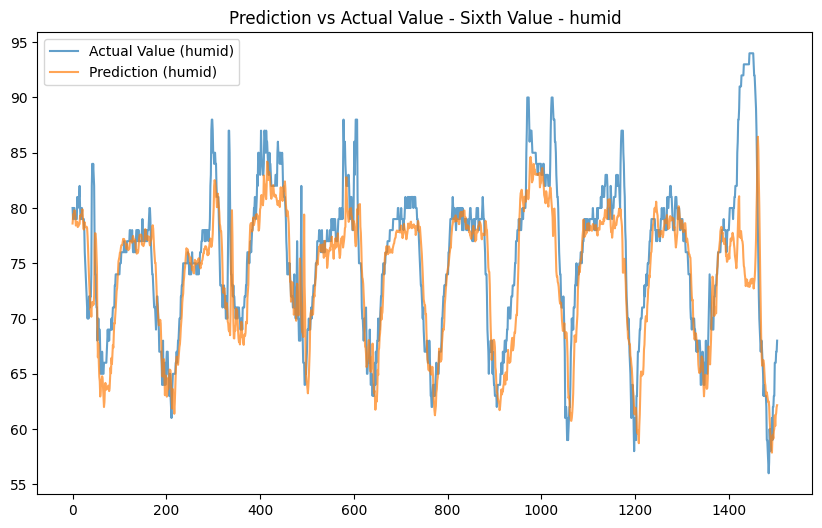

'ws40': RMSE = 1.1082, NRMSE = 0.1080, Relative Error = 13.87%


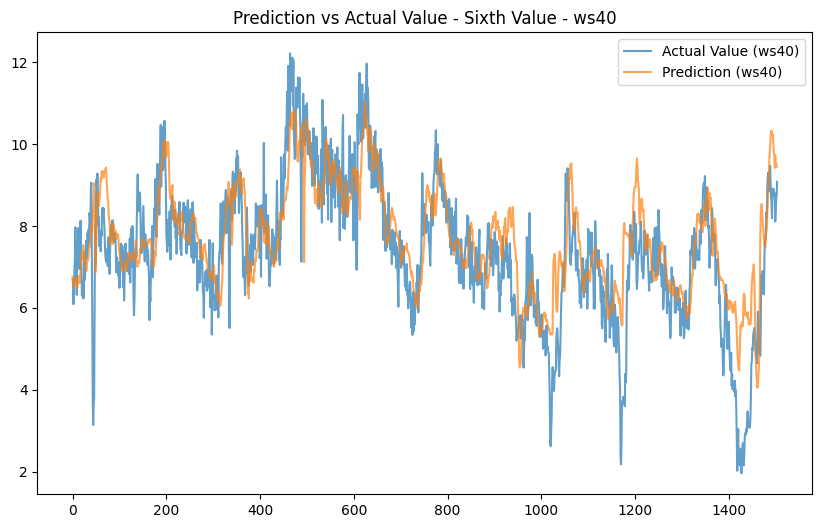

'ws50': RMSE = 1.0838, NRMSE = 0.1068, Relative Error = 12.88%


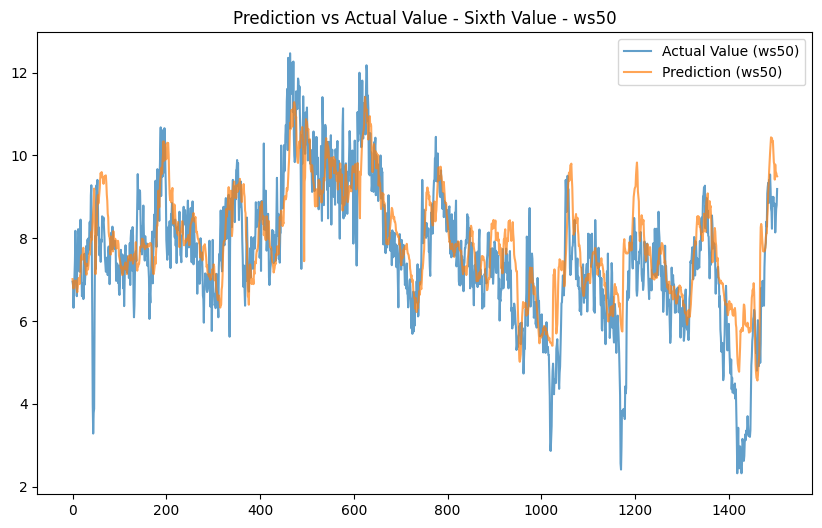

'ws60': RMSE = 1.1402, NRMSE = 0.1137, Relative Error = 13.03%


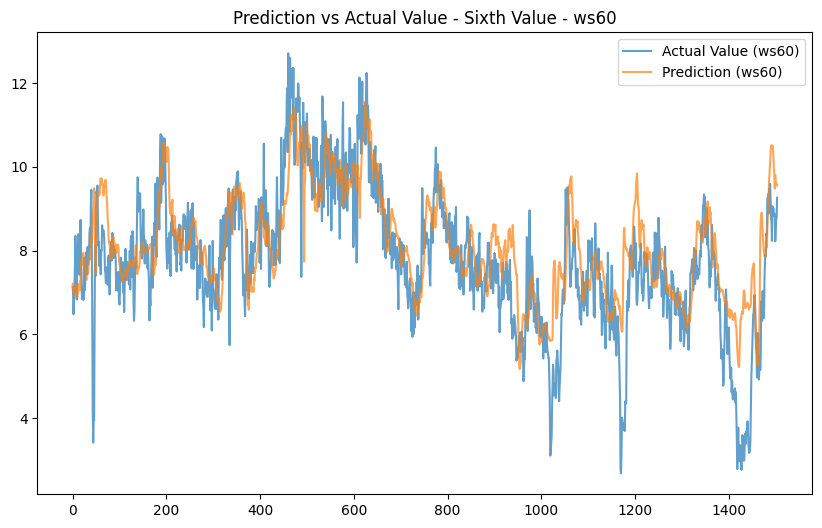

'ws70': RMSE = 1.1020, NRMSE = 0.1104, Relative Error = 12.23%


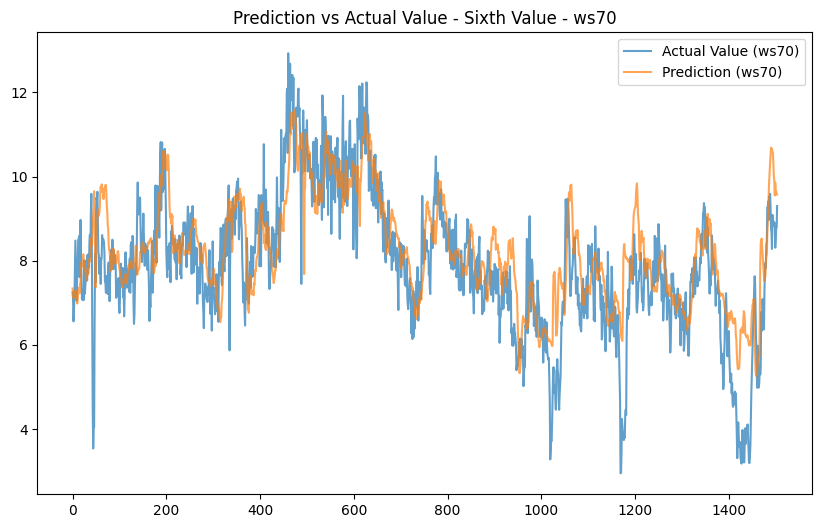

'ws80': RMSE = 1.0450, NRMSE = 0.1046, Relative Error = 11.24%


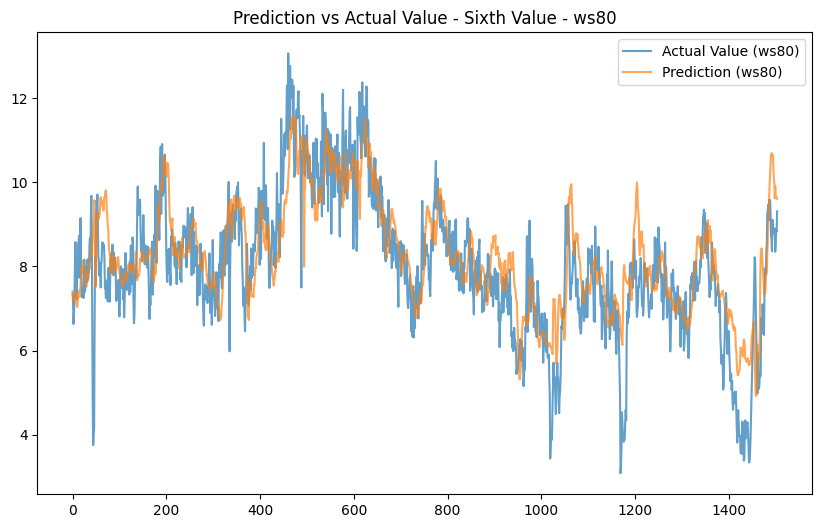

'ws90': RMSE = 1.0515, NRMSE = 0.1060, Relative Error = 11.17%


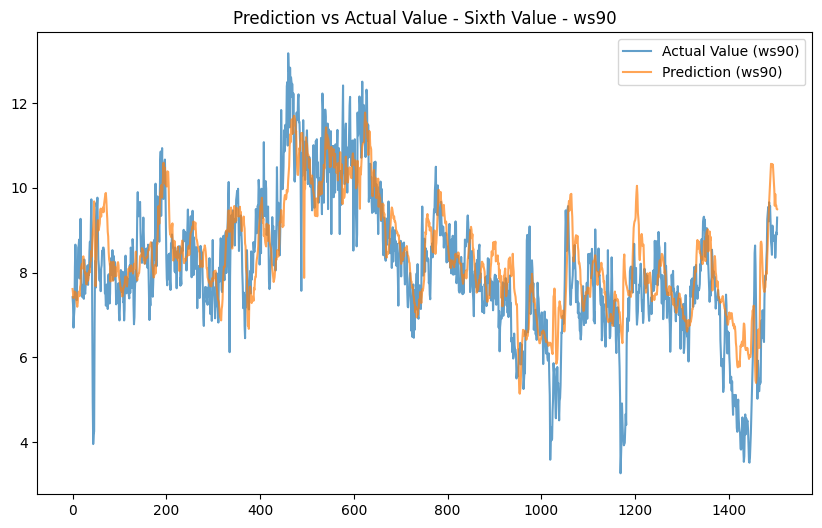

'ws100': RMSE = 1.0465, NRMSE = 0.1075, Relative Error = 10.87%


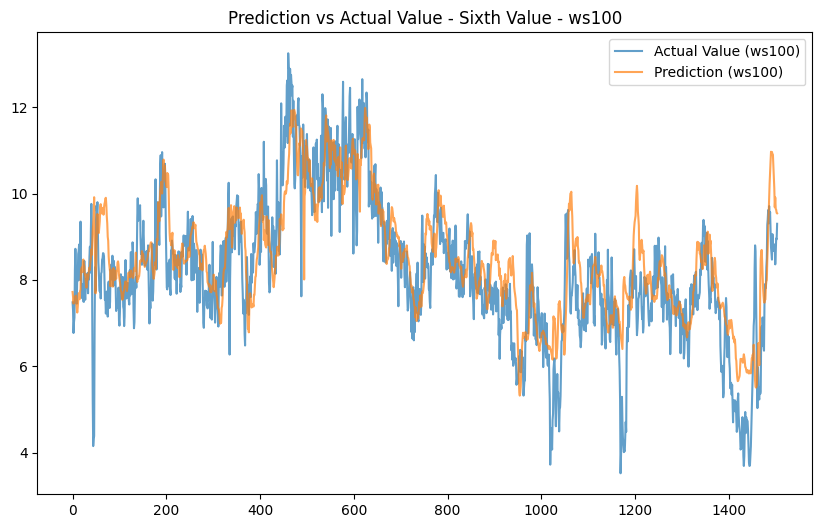

'wdisp40': RMSE = 0.2055, NRMSE = 0.1012, Relative Error = 26.64%


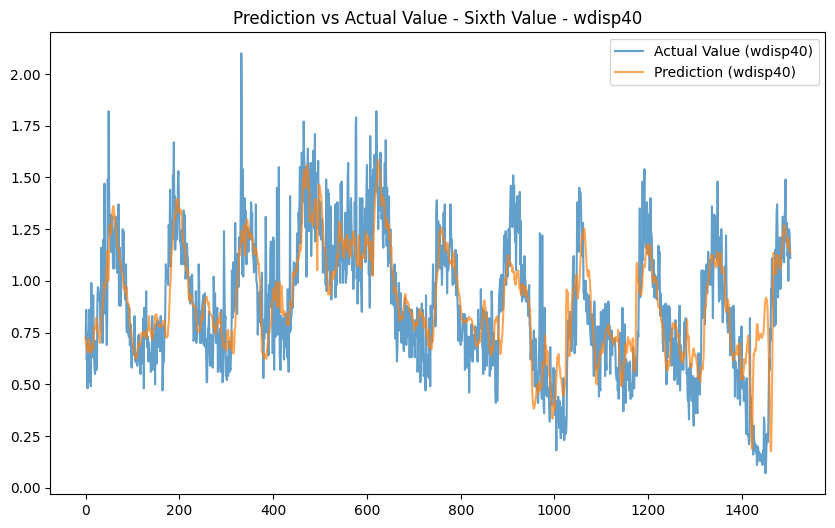

'wdisp50': RMSE = 0.2166, NRMSE = 0.1031, Relative Error = 28.34%


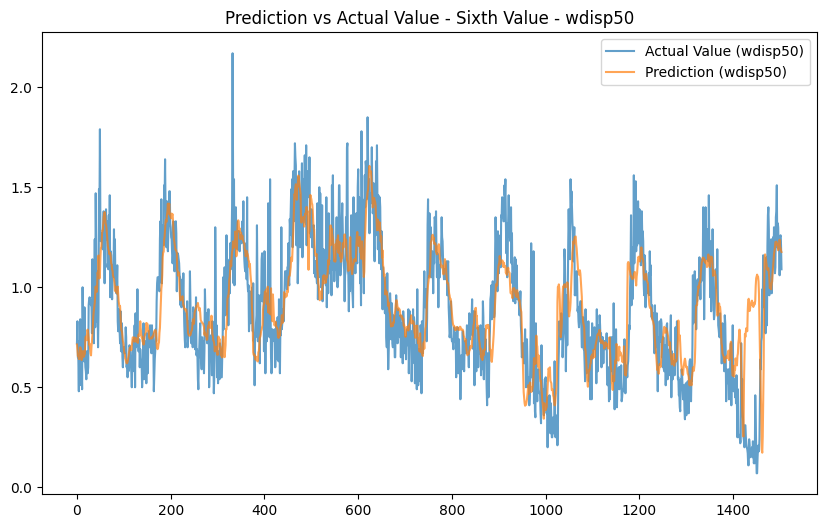

'wdisp60': RMSE = 0.2104, NRMSE = 0.1016, Relative Error = 26.33%


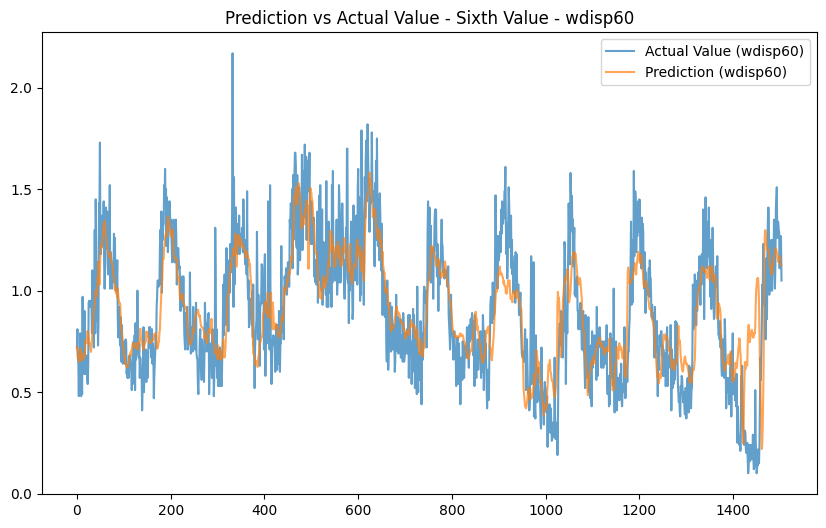

'wdisp70': RMSE = 0.2296, NRMSE = 0.1120, Relative Error = 28.83%


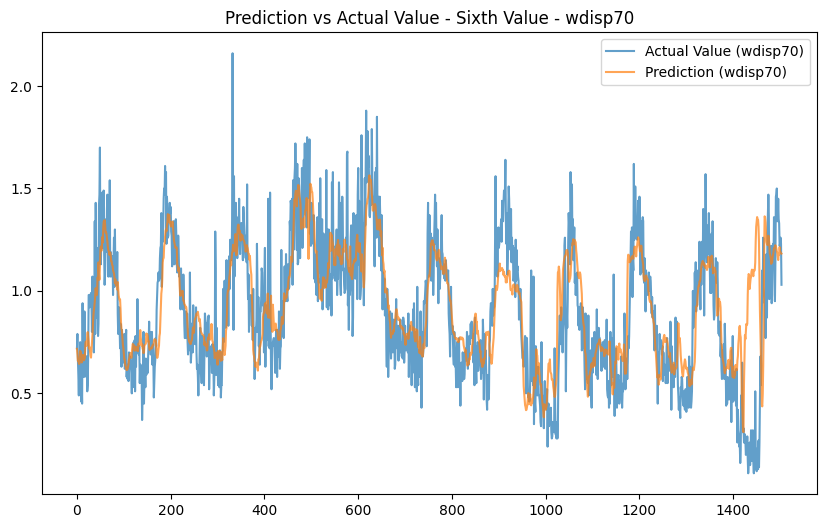

'wdisp80': RMSE = 0.2121, NRMSE = 0.1045, Relative Error = 25.21%


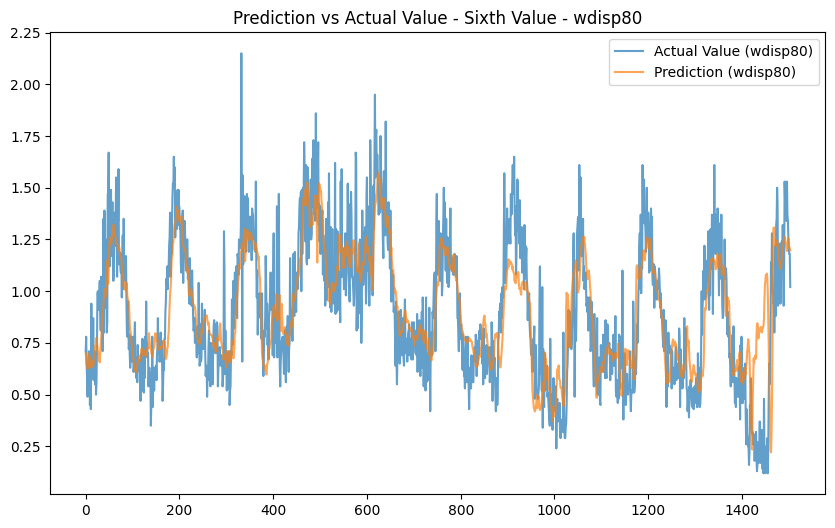

'wdisp90': RMSE = 0.2269, NRMSE = 0.1091, Relative Error = 26.93%


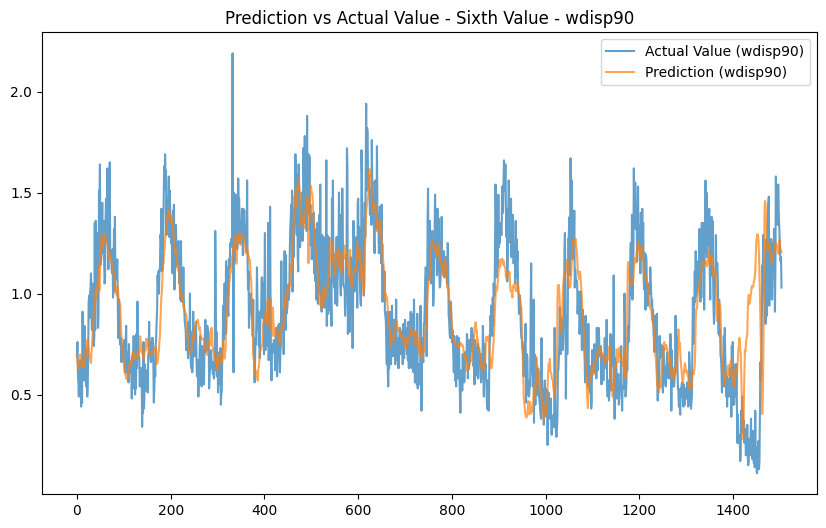

'wdisp100': RMSE = 0.2253, NRMSE = 0.1078, Relative Error = 25.52%


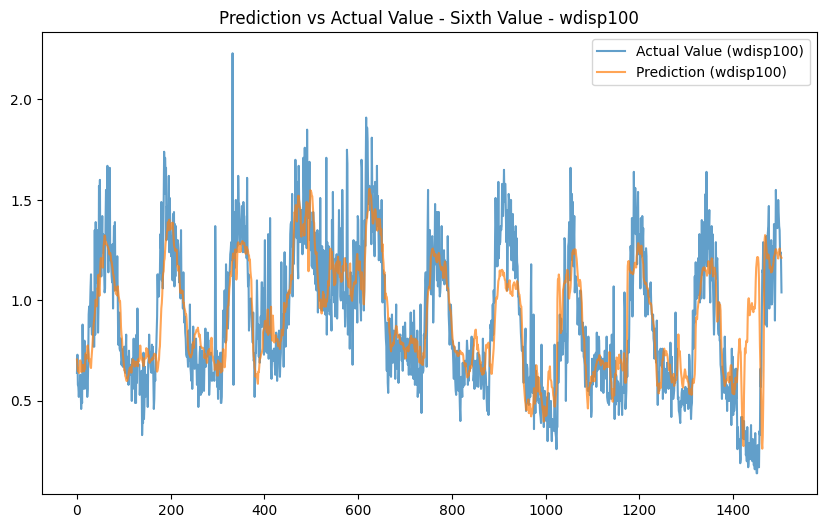

In [128]:
# Final evaluation on the test set
y_pred = model.predict(X_test)

# Inverse transform to original scale
y_pred_reshaped = y_pred.reshape(-1, len(cols))
y_pred_orig = scaler.inverse_transform(np.hstack([y_pred_reshaped, np.zeros((y_pred_reshaped.shape[0], df_for_training.shape[1] - len(cols)))]))
y_pred_orig = y_pred_orig[:, :len(cols)].reshape(-1, prediction_length, len(cols))

y_test_reshaped = y_test.reshape(-1, len(cols))
y_test_orig = scaler.inverse_transform(np.hstack([y_test_reshaped, np.zeros((y_test_reshaped.shape[0], df_for_training.shape[1] - len(cols)))]))
y_test_orig = y_test_orig[:, :len(cols)].reshape(-1, prediction_length, len(cols))

# Evaluate the sixth predicted value
for i, col in enumerate(cols):
    y_true = y_test_orig[:, 5, i]  # Sixth value (index 5)
    y_pred_col = y_pred_orig[:, 5, i]

    rmse = np.sqrt(np.mean((y_true - y_pred_col) ** 2))
    nrmse = rmse / (y_true.max() - y_true.min())
    relative_error = (np.mean(np.abs((y_true - y_pred_col) / y_true)) * 100)

    print(f"'{col}': RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}, Relative Error = {relative_error:.2f}%")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label=f"Actual Value ({col})", alpha=0.7)
    plt.plot(y_pred_col, label=f"Prediction ({col})", alpha=0.7)
    plt.legend()
    plt.title(f"Prediction vs Actual Value - Sixth Value - {col}")
    plt.show()